### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [3]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2014.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [6]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [7]:
df.head()

,year,Post
0,2014,On silence and Marshawn LynchSeattle Seahawks ...
1,2014,"When You Can’t Connect, Don’t Fix It; Let The ..."
2,2014,Getting over anxiety and staying calm in the d...
3,2014,50 Seconds to Presence [+ Audio]Originally pub...
4,2014,"15 Easy Ways to Beat Anxiety NowTechnically, a..."


In [8]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [9]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [10]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['on', 'silence', 'and', 'marshawn', 'lynchseattle', 'seahawks', 'running', 'back', 'marshawn', 'lynch', 'didn', 'talk', 'to', 'reporters', 'all', 'year', 'it', 'super', 'bowl', 'week', 'and', 'now', 'he', 'talking', 'but', 'not', 'really', 'he', 'getting', 'assistance', 'if', 'that', 'helps', 'the', 'pro', 'football', 'writers', 'of', 'america', 'aren', 'happy', 'specifically', 'they', 'are', 'extremely', 'disappointed', 'let', 'discuss', 'this', 'this', 'is', 'in', 'marshawn', 'lynch', 'contract', 'he', 'is', 'required', 'to', 'meet', 'with', 'the', 'media', 'that', 'has', 'to', 'be', 'placed', 'in', 'bold', 'speaking', 'with', 'the', 'media', 'isn', 'optional', 'it', 'contractual', 'there', 'are', 'monetary', 'penalties', 'for', 'all', 'players', 'who', 'refuse', 'to', 'speak', 'to', 'reporters', 'when', 'players', 'snub', 'reporters', 'it', 'makes', 'them', 'look', 'bad', 'and', 'it', 'makes', 'the', 'team', 'look', 'bad', 'if', 'player', 'continually', 'snubs', 'reporters', 'the'

In [11]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [12]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [13]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['on', 'silence', 'and', 'marshawn', 'lynchseattle', 'seahawks', 'running', 'back', 'marshawn', 'lynch', 'didn', 'talk', 'to', 'reporters', 'all', 'year', 'it', 'super', 'bowl', 'week', 'and', 'now', 'he', 'talking', 'but', 'not', 'really', 'he', 'getting', 'assistance', 'if', 'that', 'helps', 'the', 'pro', 'football', 'writers', 'of', 'america', 'aren', 'happy', 'specifically', 'they', 'are', 'extremely', 'disappointed', 'let', 'discuss', 'this', 'this', 'is', 'in', 'marshawn', 'lynch', 'contract', 'he', 'is', 'required', 'to', 'meet', 'with', 'the', 'media', 'that', 'has', 'to', 'be', 'placed', 'in', 'bold', 'speaking', 'with', 'the', 'media', 'isn', 'optional', 'it', 'contractual', 'there', 'are', 'monetary', 'penalties', 'for', 'all', 'players', 'who', 'refuse', 'to', 'speak', 'to', 'reporters', 'when', 'players', 'snub', 'reporters', 'it', 'makes', 'them', 'look', 'bad', 'and', 'it', 'makes', 'the', 'team', 'look', 'bad', 'if', 'player', 'continually', 'snubs', 'reporters', 'the',

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [15]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# 1. Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# 2. Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# 3. Create Corpus
texts = data_lemmatized

# 4. Term Document Frequency and Create a bag of words
bow_corpus = bow(dictionary=id2word, processed_docs=texts)

# 5. Calculate low_tfidf_words
# Keep only words with tfidf ranking <= x * len(dictionary)
x = 0.2
total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)

# 6. Filter out least frequently used words
no_below = 0.01
keep_n = 10000
dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
                                                 no_below, keep_n)

# 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)

# 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# created after least frequently and most commonly used words were filtered out.
corpus = bow(dict_tfidf_filtered, texts)

# View
[[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
num_topics = 42
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['silence', 'marshawn', 'lynchseattle', 'seahawks', 'run', 'back', 'marshawn', 'lynch', 'talk', 'reporter', 'year', 'super', 'bowl', 'week', 'talk', 'really', 'get', 'assistance', 'help', 'pro', 'football', 'writer', 'america', 'happy', 'specifically', 'extremely', 'disappointed', 'let', 'discuss', 'marshawn', 'lynch', 'contract', 'require', 'meet', 'medium', 'place', 'bold', 'speak', 'medium', 'optional', 'contractual', 'monetary', 'penalty', 'player', 'refuse', 'speak', 'reporter', 'player', 'snub', 'reporter', 'make', 'look', 'bad', 'make', 'team', 'look', 'bad', 'player', 'continually', 'snub', 'reporter', 'reporter', 'go', 'right', 'team', 'brass', 'need', 'reporter', 'boss', 'go', 'right', 'team', 'brass', 'sponsorship', 'advertising', 'deal', 'significant', 'medium', 'remind', 'team', 'report', 'receive', 'positive', 'press', 'privilege', 'expectation', 'medium', 'team', 'relationship', 'partnership', 'mutual', 'benefit', 'say', 'let', 'step', 'away', 'lynch', 'talk', 'personal

In [17]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(20,
  '0.000*"grade" + 0.000*"frustration" + 0.000*"extremely" + 0.000*"memory" + '
  '0.000*"flight" + 0.000*"gift" + 0.000*"habit" + 0.000*"student" + '
  '0.000*"sleep" + 0.000*"search"'),
 (34,
  '0.000*"damn" + 0.000*"goal" + 0.000*"conversation" + 0.000*"article" + '
  '0.000*"phone" + 0.000*"exercise" + 0.000*"book" + 0.000*"willing" + '
  '0.000*"blood" + 0.000*"shit"'),
 (7,
  '0.000*"frustration" + 0.000*"sleep" + 0.000*"symptom" + 0.000*"reduce" + '
  '0.000*"class" + 0.000*"meditation" + 0.000*"flight" + 0.000*"memory" + '
  '0.000*"angry" + 0.000*"difference"'),
 (36,
  '0.001*"sad" + 0.000*"city" + 0.000*"park" + 0.000*"katie" + 0.000*"guilt" + '
  '0.000*"food" + 0.000*"sleep" + 0.000*"reflection" + 0.000*"meditation" + '
  '0.000*"plan"'),
 (15,
  '0.001*"woman" + 0.000*"sleep" + 0.000*"screen" + 0.000*"disorder" + '
  '0.000*"symptom" + 0.000*"reduce" + 0.000*"university" + 0.000*"department" '
  '+ 0.000*"study" + 0.000*"psychological"'),
 (18,
  '0.001*"woman" + 0.

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.965094614663451


In [19]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4824200261742866


In [20]:
topic_words = []
for i in range(num_topics):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])
for i in range(0,num_topics):
    print(topic_words[i])

['disorder', 'woman', 'audience', 'man', 'task', 'bill_friend', 'petition', 'screen', 'weight', 'bathroom']
['woman', 'screen', 'petition', 'twitter', 'frustration', 'postpartum', 'tweet', 'angry', 'care', 'disorder']
['return', 'glove', 'store', 'woman', 'buy', 'memory', 'exchange', 'dad', 'search', 'petition']
['tiger', 'danger', 'possible', 'imagine', 'perceive', 'surprise', 'outcome', 'react', 'hormone', 'co']
['stretch', 'overcome', 'string', 'skill', 'doubt', 'conquer', 'man', 'produce', 'confident', 'suggest']
['memory', 'woman', 'result', 'outcome', 'introduce', 'exercise', 'search', 'assumption', 'subconscious', 'screen']
['check', 'text', 'bank', 'phone', 'relationship', 'account', 'banking', 'money', 'terrible', 'yet']
['frustration', 'sleep', 'symptom', 'reduce', 'class', 'meditation', 'flight', 'memory', 'angry', 'difference']
['truth', 'goal', 'require', 'damn', 'trust', 'apologize', 'sorry', 'blood', 'fat', 'willing']
['memory', 'late', 'confidence', 'audience', 'check',

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [22]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,24.0,0.9928,"medium, player, reporter, team, marshawn, lync...","[silence, marshawn, lynchseattle, seahawks, ru..."
1,1,39.0,0.9959,"fire, clean, class, connect, fix, heavy, happi...","[connect, fix, let, fire, take, youoriginally,..."
2,2,41.0,0.9611,"skip, article, phone, drink, pm, dinner, compu...","[get, anxiety, stay, calm, digital, worldbut, ..."
3,3,28.0,0.9911,"exercise, writer, mindfulness, yaga, breathe, ...","[second, presence, audio, originally_publishe,..."
4,4,27.0,0.9634,"university, reduce, sleep, symptom, meditation...","[easy, way, beat, anxiety, nowtechnically, anx..."


In [23]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,24.0,0.9928,"medium, player, reporter, team, marshawn, lync...","[silence, marshawn, lynchseattle, seahawks, ru..."
1,1,39.0,0.9959,"fire, clean, class, connect, fix, heavy, happi...","[connect, fix, let, fire, take, youoriginally,..."
2,2,41.0,0.9611,"skip, article, phone, drink, pm, dinner, compu...","[get, anxiety, stay, calm, digital, worldbut, ..."
3,3,28.0,0.9911,"exercise, writer, mindfulness, yaga, breathe, ...","[second, presence, audio, originally_publishe,..."
4,4,27.0,0.9634,"university, reduce, sleep, symptom, meditation...","[easy, way, beat, anxiety, nowtechnically, anx..."
5,5,27.0,0.9586,"university, reduce, sleep, symptom, meditation...","[way, reduce, daily, anxiety, nowtechnically, ..."
6,6,1.0,0.9979,"woman, screen, petition, twitter, frustration,...","[sign, petition, save, mother, liveswritten, d..."
7,7,8.0,0.9931,"truth, goal, require, damn, trust, apologize, ...","[whir, clickingwho, teach, hope, cruel, hope, ..."
8,8,28.0,0.9829,"exercise, writer, mindfulness, yaga, breathe, ...","[ask, baba, yaga, quit, worry, finding, let, h..."
9,9,4.0,0.9897,"stretch, overcome, string, skill, doubt, conqu...","[overcome, stress, stretchstress, part, live, ..."


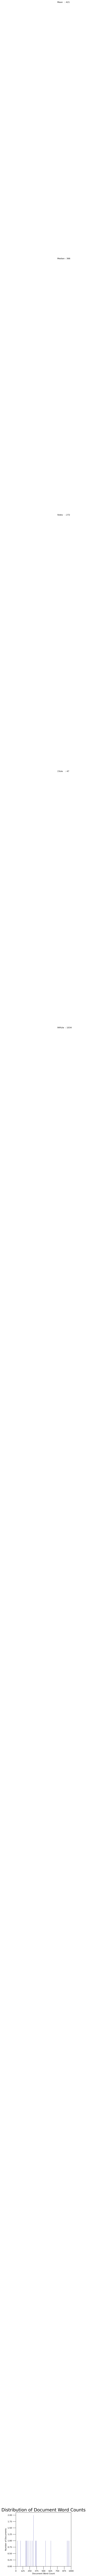

In [63]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

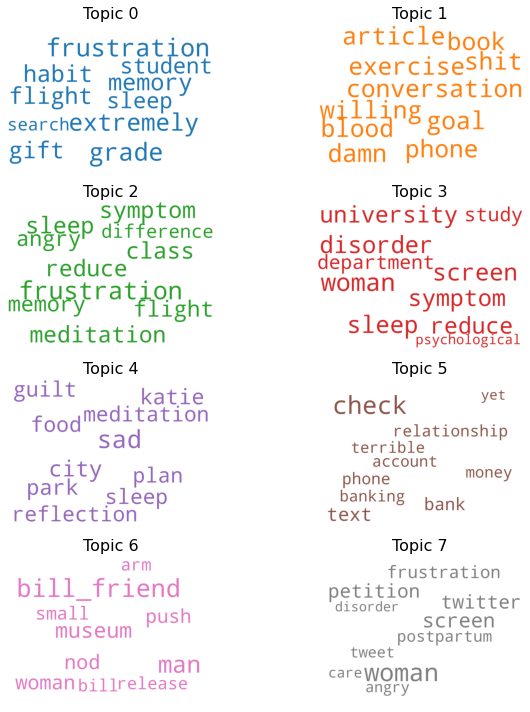

In [24]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [25]:
df_dominant_topic.to_csv("Medium2014.csv")

In [26]:
topic_words = []
for i in range(num_topics):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [27]:
df2=pd.DataFrame({'Year':[],'Source':[],'Topic_ID':[],'Most_freq_words':[]})
df2.head()

,Year,Source,Topic_ID,Most_freq_words


In [28]:
df2['Most_freq_words']=topic_words
df2 = df2.assign(Year=2014)
df2 = df2.assign(Source='Medium')
df2.shape

(42, 4)

In [29]:
ls=[]
for i in range(0,num_topics):
    ls.append(i)
df2['Topic_ID']=ls
df2.head()

,Year,Source,Topic_ID,Most_freq_words
0,2014,Medium,0,"[disorder, woman, audience, man, task, bill_fr..."
1,2014,Medium,1,"[woman, screen, petition, twitter, frustration..."
2,2014,Medium,2,"[return, glove, store, woman, buy, memory, exc..."
3,2014,Medium,3,"[tiger, danger, possible, imagine, perceive, s..."
4,2014,Medium,4,"[stretch, overcome, string, skill, doubt, conq..."


In [30]:
df2.to_csv("topic_words_m2014.csv")

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=6):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=50, step=8)

(42, 0.010876102480690153, 0.42872901624755094)

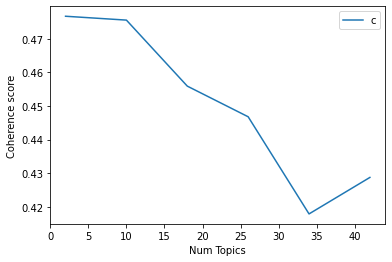

In [51]:
# Show graph
limit=50; start=2; step=8;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)